# Lab 8
## Ian Grant

In [1]:
import geopandas as gpd
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt

First, I read the files and converted them to DataFrames. In the case of the state code dict, I used ast.as_literal to interpret the string as a dictionary.

In [2]:
wd = os.getcwd()
counties_path = "gz_2010_us_050_00_20m.geojson"
fips_path = "fipsToState.json"
data_dir = os.path.join(wd, "data")

# Read county dataset as GeoDataframe
gdf_counties = gpd.read_file(os.path.join(data_dir, counties_path))

# Read state code file, make state code dict, and create Dataframe of state codes
fips_file = open(os.path.join(data_dir, fips_path), "r")
fips_string = fips_file.read().replace("\n", "")
state_code_dict = ast.literal_eval(fips_string)
df_state_codes = pd.DataFrame(
    {"STATE": state_code_dict.keys(), "state_name": state_code_dict.values()}
)

# Merge the state names into the county dataset
gdf_counties = pd.merge(gdf_counties, df_state_codes, how="left", on="STATE")

Next, I defined a function that returns a Series where the index is the unique values of a given column in the dataframe and the values are the counts of those values.

I used this function to define another function that gives only the n most frequent values.

In [3]:
def counts(df, col):
    """Returns a dataframe with counts for each value of col."""
    first_col_name = df.columns[0]
    counts = df.groupby(by=col).count()[first_col_name].rename("Counts")
    return counts

def n_most_frequent(df, col, n):
    """Returns a dict of the n largest values of n in the dataframe df."""
    top_n = counts(df, col).nlargest(n)
    return top_n

print(n_most_frequent(gdf_counties, "NAME", 5))

NAME
Washington    31
Franklin      26
Jefferson     26
Jackson       24
Lincoln       24
Name: Counts, dtype: int64


Next, I defined a function that provides summary statistics for a dataframe. The user specifies the column to group by and the column with the values to be summarized.

In [4]:
def summarize_df(df, group_col, val_col):
    """"""
    groups = df.groupby(group_col)
    summary = pd.DataFrame(
        {
            # "state": groups.any("state_name"),
            "max": groups.max(val_col)[val_col],
            "min": groups.min(val_col)[val_col],
            "mean": groups.mean(val_col)[val_col],
            "sum": groups.sum(val_col)[val_col],
            "count": groups.count()[val_col],
        }
    )
    return summary

county_areas_by_state = summarize_df(gdf_counties, "state_name", "CENSUSAREA")
print(county_areas_by_state)

                             max       min          mean         sum  count
state_name                                                                 
Alabama                 1589.784   534.991    755.900373   50645.325     67
Alaska                145504.789   452.325  19677.274172  570640.951     29
Arizona                18618.885  1236.916   7572.939000  113594.085     15
Arkansas                1039.214   528.268    693.806373   52035.478     75
California             20056.938    46.873   2685.848586  155779.218     58
Colorado                4772.672    33.034   1619.404500  103641.888     64
Connecticut              920.560   369.301    605.294500    4842.356      8
Delaware                 936.079   426.286    649.514667    1948.544      3
District of Columbia      61.048    61.048     61.048000      61.048      1
Florida                 1998.324   243.556    800.369537   53624.759     67
Geogia                   892.461   119.200    361.720057   57513.489    159
Hawaii      

Finally, I wrote a script to plot the five most frequent counties. I also calculated a new column so that the counts of the counties are included in their legend entries.


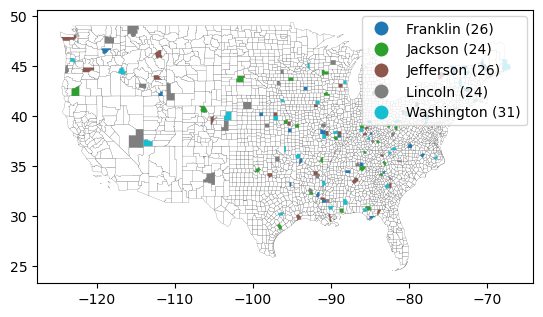

In [7]:
fig, ax = plt.subplots()
ax.set_aspect("equal")

frequent_counties = n_most_frequent(gdf_counties, "NAME", 5)

# Drop Hawaii, Alaska, and Puerto Rico to facilitate plotting
df_plot = gdf_counties[
    (gdf_counties["state_name"] != "Hawaii")
    & (gdf_counties["state_name"] != "Alaska")
    & (gdf_counties["STATE"] != "72")
]

# Plot base layer
df_plot.plot(ax=ax, color="white", edgecolor="black", linewidth=0.1)

# Build query string
query_string = " | ".join(
    ["NAME == " + f"'{county}'" for county in frequent_counties.index]
)

# Filter GeoDataFrame to counties of interest with query string
df_plot = gdf_counties.query(query_string)

# Merge counts into plotting GeoDataFrame
df_plot = pd.merge(
    df_plot, pd.DataFrame(frequent_counties), how="left", on="NAME", copy=False
)

# Convert Counts column to string
df_plot.Counts = df_plot.Counts.astype(str)

# Create new column for legend labels that includes counts
df_plot = df_plot.assign(legend_labels=lambda df: df.NAME + " (" + df.Counts + ")")

# Plot GeoDataFrame and color by county name
df_plot.plot(ax=ax, column="legend_labels", legend=True)
plt.show()
plt.close()